In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import os
import random

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv('../data/train.csv')

In [3]:
# df.head()
df.shape

(1951, 15)

In [4]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

# SMILES 데이터를 분자 지문으로 변환
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # print(mol)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=CFG['NBITS'])
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))
chembl_data = pd.read_csv('../data/train.csv')  # 예시 파일 이름
chembl_data.head()

train = chembl_data[['Smiles', 'pIC50']]
train['Fingerprint'] = train['Smiles'].apply(smiles_to_fingerprint)

[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerator
[10:54:08] DEPRECATION WARNING: please use MorganGenerat

In [5]:
# smile to image
# btrain = chembl_data[['Standard Value', 'IC50_nM']]
# remove_duplicated = set()
# type(chembl_data['Standard Value'][1])
# for idx, tra in enumerate(chembl_data['Smiles']):
#     remove_duplicated.add(tra)
#     mol = Chem.MolFromSmiles(tra)
#     img = Draw.MolToImage(mol)
#     img.save(f'./img/mol{idx}.png')

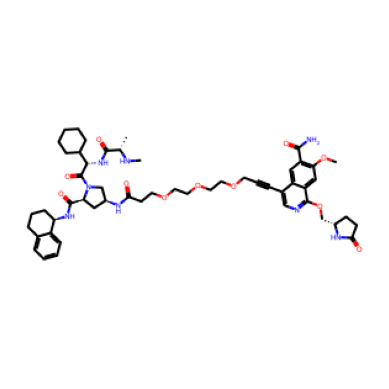

In [6]:
img = mpimg.imread('./img/mol0.png')
plt.imshow(img)
plt.axis('off')  # 축을 숨깁니다.
plt.show()  # 이미지를 화면에 표시합니다.

In [7]:
img.shape

(300, 300, 3)

In [8]:
class resnet(nn.Module):
    def __init__(self):
        super(resnet, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=64, kernel_size=7, stride=2,padding=3)
        self.max_pool1 = nn.MaxPool3d(kernel_size=2)
        self.conv2 = nn.Conv3d(in_channels=3, out_channels=64, kernel_size=7, stride=2,padding=3)
        self.avg_pool1 = nn.AvgPool3d(kernel_size=2)
        self.fc1 = nn.Linear()
        self.fc2 = nn.Linear(50, 10)

In [9]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection for matching dimensions
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers with additional BasicBlock layers
        self.layer1 = self._make_layer(64, 64, stride=1, num_blocks=4)
        self.layer2 = self._make_layer(64, 128, stride=2, num_blocks=4)
        self.layer3 = self._make_layer(128, 256, stride=2, num_blocks=4)
        self.layer4 = self._make_layer(256, 512, stride=2, num_blocks=4)

        self.avg_pool1 = nn.AdaptiveAvgPool2d((1, 1))
        
        # fc layers (fully connected layers)
        self.fc1 = nn.Linear(512, 256)  # 첫 번째 fc 레이어
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)    # 두 번째 fc 레이어

    def _make_layer(self, in_channels, out_channels, stride, num_blocks):
        layers = [BasicBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.max_pool1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool1(x)
        x = torch.flatten(x, 1)
        
        # 통과 시킬 fc 레이어
        x = F.relu(self.fc1(x))  # 첫 번째 fc 레이어에 ReLU 활성화 함수 적용
        x = self.dropout(x)
        x = self.fc2(x)          # 두 번째 fc 레이어
        return x


In [10]:
# ## image augmentation 전
# import os
# import pandas as pd
# from PIL import Image
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms

# class CustomImageDataset(Dataset):
#     def __init__(self, img_dir, csv_file, transform=None):
#         self.img_dir = img_dir
#         self.transform = transform
#         self.img_labels = pd.read_csv(csv_file)

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         # 이미지 이름 생성: "mol1.png", "mol2.png", ..., "mol1951.png"
#         img_name = f"mol{idx + 1}.png"  # idx는 0부터 시작하므로 +1을 추가
#         img_path = os.path.join(self.img_dir, img_name)
#         image = Image.open(img_path).convert("RGB")
        
#         label = self.img_labels.iloc[idx, 13]  # CSV의 첫 번째 열이 pIC50 값이라고 가정
#         label = torch.tensor(label, dtype=torch.float32)
        
#         if self.transform:
#             image = self.transform(image)
            
#         return image, label
# img_dir = './img'  # 이미지 파일들이 저장된 디렉토리
# csv_file = '../data/train.csv'  # 레이블이 저장된 CSV 파일의 경로

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # ResNet에 적합한 크기로 조정
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# dataset = CustomImageDataset(img_dir=img_dir, csv_file=csv_file, transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [11]:
## image augmentation 후
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = pd.read_csv(csv_file)

        # 레이블 데이터가 숫자형인지 확인하고, 문자열일 경우 변환
        self.img_labels.iloc[:, 0] = pd.to_numeric(self.img_labels.iloc[:, 0], errors='coerce')

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = f"mol{idx}.png"  # idx를 그대로 사용하여 0부터 시작하는 이미지 이름 생성
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        label = self.img_labels.iloc[idx, 13]  # CSV의 첫 번째 열이 레이블(pIC50 값)이라고 가정
        label = torch.tensor(label, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


# 이미지 전처리 및 증강 정의
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 0.9)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 및 데이터 로더 초기화
img_dir = './img'  # 이미지 파일들이 저장된 디렉토리
csv_file = './train.csv'  # 레이블이 저장된 CSV 파일의 경로

dataset = CustomImageDataset(img_dir=img_dir, csv_file=csv_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)


In [12]:
#
import torch.nn as nn
import torchvision.models as models

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 1)  # 출력 노드를 1로 변경 (회귀용)

    def forward(self, x):
        return self.model(x)

model = ResNet()

# 모델을 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.MSELoss()  # 회귀 작업에 적합한 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



/data/2_data_server/cv-07/anaconda3/envs/koreatech/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/2_data_server/cv-07/anaconda3/envs/koreatech/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# datda augmentation 후
num_epochs = 10  # 원하는 에포크 수로 설정

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


Epoch 1/10, Loss: 0.2355
Epoch 2/10, Loss: 0.2401
Epoch 3/10, Loss: 0.2383
Epoch 4/10, Loss: 0.2356
Epoch 5/10, Loss: 0.2388
Epoch 6/10, Loss: 0.2539
Epoch 7/10, Loss: 0.2411
Epoch 8/10, Loss: 0.2323
Epoch 9/10, Loss: 0.2453
Epoch 10/10, Loss: 0.2484


In [14]:
# 학습된 모델 저장
torch.save(model.state_dict(), 'resnet_augmentation.pth')

In [65]:
# # ResNet18 모델을 불러오고, 마지막 레이어를 수정
# model = ResNet()
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 1)  # 출력이 1인 회귀용 레이어

# # 모델을 GPU로 이동 (가능한 경우)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

In [66]:
# criterion = nn.MSELoss()  # 회귀 작업에 적합한 손실 함수
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# num_epochs = 10  # 학습 에포크 수

# for epoch in range(num_epochs):
#     model.train()  # 모델을 학습 모드로 설정
#     running_loss = 0.0
#     for inputs, labels in dataloader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()  # 옵티마이저 초기화

#         outputs = model(inputs)  # 순전파
#         loss = criterion(outputs.squeeze(), labels)  # 손실 계산
        
#         loss.backward()  # 역전파
#         optimizer.step()  # 옵티마이저 스텝
        
#         running_loss += loss.item() * inputs.size(0)

#     epoch_loss = running_loss / len(dataloader.dataset)
#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


In [24]:
# torch.save(model.state_dict(), 'resnet_regression_model.pth')

In [16]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

# SMILES 데이터를 분자 지문으로 변환
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # print(mol)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=CFG['NBITS'])
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))
test_data = pd.read_csv('../data/test.csv')  # 예시 파일 이름
test_data.head()

train = test_data[['Smiles']]
train['Fingerprint'] = train['Smiles'].apply(smiles_to_fingerprint)

[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerator
[11:01:21] DEPRECATION WARNING: please use MorganGenerat

In [17]:
# btrain = test_data[['Standard Value']]
remove_duplicated = set()
# type(test_data['Standard Value'][1])
for idx, tra in enumerate(test_data['Smiles']):
    remove_duplicated.add(tra)
    mol = Chem.MolFromSmiles(tra)
    img = Draw.MolToImage(mol)
    img.save(f'./test_img/mol{idx}.png')

In [18]:
# df.head()
df.shape

(1951, 15)

In [19]:
import os
import pandas as pd
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

# 1. 모델 정의 및 저장된 파라미터 불러오기
model = ResNet()  # ResNet 모델 정의
model.load_state_dict(torch.load('resnet_augmentation.pth'))  # 저장된 모델 파라미터 로드
model.eval()  # 평가 모드로 전환

# 2. 이미지 전처리 준비
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 3. sample_submission.csv 파일 열기
submission_df = pd.read_csv('sample_submission.csv')

# 4. 이미지 파일 순회하며 예측 수행
test_img_dir = './test_img'
predicted_ic50_values = []

for idx in range(113):  # 0부터 112까지 순회
    img_name = f"mol{idx}.png"
    img_path = os.path.join(test_img_dir, img_name)

    if os.path.exists(img_path):
        image = Image.open(img_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)

        predicted_pIC50 = output.item()  # 예측된 pIC50 값 추출

        # pIC50 값을 IC50_nM으로 변환
        predicted_IC50_nM = 10 ** (9 - predicted_pIC50)
        predicted_ic50_values.append(predicted_IC50_nM)

        print(f'{img_name}: Predicted IC50_nM value = {predicted_IC50_nM:.4f}')
    else:
        print(f'{img_name} does not exist.')

# 5. sample_submission.csv에 예측 값 넣기
submission_df['IC50_nM'] = predicted_ic50_values

# 6. 변경된 데이터프레임을 새로운 CSV 파일로 저장
submission_df.to_csv('submission_with_ic50.csv', index=False)


/data/2_data_server/cv-07/anaconda3/envs/koreatech/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/2_data_server/cv-07/anaconda3/envs/koreatech/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


mol0.png: Predicted IC50_nM value = 22.7775
mol1.png: Predicted IC50_nM value = 9.8927
mol2.png: Predicted IC50_nM value = 13.2810
mol3.png: Predicted IC50_nM value = 13.3278
mol4.png: Predicted IC50_nM value = 6.6963
mol5.png: Predicted IC50_nM value = 1.6226
mol6.png: Predicted IC50_nM value = 12.3565
mol7.png: Predicted IC50_nM value = 7.3958
mol8.png: Predicted IC50_nM value = 64.3985
mol9.png: Predicted IC50_nM value = 17.2801
mol10.png: Predicted IC50_nM value = 1.5494
mol11.png: Predicted IC50_nM value = 78.2490
mol12.png: Predicted IC50_nM value = 5.9811
mol13.png: Predicted IC50_nM value = 25.7197
mol14.png: Predicted IC50_nM value = 15.0697
mol15.png: Predicted IC50_nM value = 12.8339
mol16.png: Predicted IC50_nM value = 8.9347
mol17.png: Predicted IC50_nM value = 18.7737
mol18.png: Predicted IC50_nM value = 7.7206
mol19.png: Predicted IC50_nM value = 21.1797
mol20.png: Predicted IC50_nM value = 6.1804
mol21.png: Predicted IC50_nM value = 9.9257
mol22.png: Predicted IC50_nM v